In [31]:
using Pkg
pkg"activate ."
pkg"instantiate"

 Activating environment at `~/Documents/otimizacao-em-julia/notebooks/Project.toml`


In [32]:
using Plots, Interact, LinearAlgebra, ForwardDiff
gr(size=(600,400))

Plots.GRBackend()

In [33]:
using NLPModels, LinearOperators, Krylov, CUTEst, SolverTools, SolverBenchmark

In [34]:
function gradiente(
        nlp :: AbstractNLPModel;
        max_time = 3.0,
        max_iter = 10_000,
        η₁ = 1e-2,
        atol = 1e-6,
        rtol = 1e-6,
)
    
    t₀ = time()
    Δt = time() - t₀
    iter = 0
    
    x = copy(nlp.meta.x0)
    f(x) = obj(nlp, x)
    ∇f(x) = grad(nlp, x)
    fx = f(x)
    gx = ∇f(x)
    
    x⁺ = similar(x)
    
    ϵ = atol + rtol * norm(gx)
    
    status = :unknown
    
    # Cond. de parada
    resolvido = norm(gx) < ϵ # true ou false
    cansado = Δt > max_time || iter > max_iter
    while !(resolvido || cansado) # Não tiver satisfeito as condições de parada
        # Calculo a direção e passo e xₖ₊₁
        d = -gx
        slope = dot(gx, d)
        
        α = 1.0
        x⁺ = x + α * d
        f⁺ = f(x⁺)
        while f⁺ ≥ fx + η₁ * α * slope
            α = α / 2
            x⁺ = x + α * d
            f⁺ = f(x⁺)
            if α < 1e-8
                status = :small_step
                break
            end
        end
        if status != :unknown
            break
        end
        x .= x⁺
        fx = f⁺
        gx = ∇f(x)
        
        resolvido = norm(gx) < ϵ
        Δt = time() - t₀
        iter += 1
        cansado = Δt > max_time || iter > max_iter
    end
    
    
    if resolvido
        status = :first_order
    elseif cansado
        if Δt > max_time
            status = :max_time
        elseif iter > max_iter
            status = :max_iter
        end
    end
    
    return GenericExecutionStats(status, nlp, objective=fx,
        solution=x, dual_feas=norm(gx), iter=iter, elapsed_time=Δt)
end

gradiente (generic function with 1 method)

In [35]:
nlp = ADNLPModel(
    x -> (x[1] - 1)^2 + 100 * (x[2] - x[1]^2)^2,
    [-1.2; 1.0]
)

ADNLPModel - Model with automatic differentiation
  Problem name: Generic
   All variables: ████████████████████ 2      All constraints: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
            free: ████████████████████ 2                 free: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           lower: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                lower: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           upper: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                upper: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
         low/upp: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0              low/upp: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           fixed: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                fixed: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
          infeas: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0               infeas: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
            nnzh: (  0.00% sparsity)   3               linear: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
                                                    nonlinear: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
                                                         nnzj: (------% sparsity)         

  Counters:
   

In [36]:
obj(nlp, nlp.meta.x0)

24.199999999999996

In [37]:
grad(nlp, nlp.meta.x0)

2-element Array{Float64,1}:
 -215.59999999999997
  -87.99999999999999

In [38]:
hess(nlp, nlp.meta.x0)

2×2 Array{Float64,2}:
 1330.0    0.0
  480.0  200.0

In [39]:
output = gradiente(nlp)
println(output)

Generic Execution stats
  status: first-order stationary
  objective value: 3.2919370907805474e-8
  primal feasibility: 0.0
  dual feasibility: 0.00022954072701882275
  solution: [0.9998188896482056  0.9996367239274359]
  iterations: 6844
  elapsed time: 0.04761695861816406


In [40]:
using JSOSolvers

In [41]:
using Logging

output = with_logger(NullLogger()) do
    lbfgs(nlp)
end
println(output)

Generic Execution stats
  status: first-order stationary
  objective value: 1.4456062568367973e-17
  primal feasibility: 0.0
  dual feasibility: 8.411318231101534e-8
  solution: [1.00000000337829  1.000000006582132]
  iterations: 39
  elapsed time: 0.0005838871002197266


In [42]:
output = with_logger(NullLogger()) do
    trunk(nlp)
end
println(output)

Generic Execution stats
  status: first-order stationary
  objective value: 3.879164521543824e-15
  primal feasibility: 0.0
  dual feasibility: 5.566318838683686e-8
  solution: [0.9999999377667473  0.9999998752847661]
  iterations: 23
  elapsed time: 0.022732973098754883


In [47]:
hess(nlp, nlp.meta.x0) * ones(2)

2-element Array{Float64,1}:
 1330.0
  680.0

In [62]:
function newton(
        nlp :: AbstractNLPModel;
        max_time = 3.0,
        max_iter = 10_000,
        η₁ = 1e-2,
        atol = 1e-6,
        rtol = 1e-6,
)
    
    t₀ = time()
    Δt = time() - t₀
    iter = 0
    
    x = copy(nlp.meta.x0)
    f(x) = obj(nlp, x)
    ∇f(x) = grad(nlp, x)
    H(x) = Symmetric(hess(nlp, x), :L)
    fx = f(x)
    gx = ∇f(x)
    
    x⁺ = similar(x)
    
    ϵ = atol + rtol * norm(gx)
    
    status = :unknown
    
    # Cond. de parada
    resolvido = norm(gx) < ϵ # true ou false
    cansado = Δt > max_time || iter > max_iter
    while !(resolvido || cansado) # Não tiver satisfeito as condições de parada
        # Calculo a direção e passo e xₖ₊₁
        Hx = H(x)
        F = cholesky(Hx, check=false)
        if !issuccess(F)
            status = :not_desc
            break
        end
        d = -(F \ gx)
        slope = dot(gx, d)
        
        α = 1.0
        x⁺ = x + α * d
        f⁺ = f(x⁺)
        while f⁺ ≥ fx + η₁ * α * slope
            α = α / 2
            x⁺ = x + α * d
            f⁺ = f(x⁺)
            if α < 1e-8
                status = :small_step
                break
            end
        end
        if status != :unknown
            break
        end
        x .= x⁺
        fx = f⁺
        gx = ∇f(x)
        
        resolvido = norm(gx) < ϵ
        Δt = time() - t₀
        iter += 1
        cansado = Δt > max_time || iter > max_iter
    end
    
    
    if resolvido
        status = :first_order
    elseif cansado
        if Δt > max_time
            status = :max_time
        elseif iter > max_iter
            status = :max_iter
        end
    end
    
    return GenericExecutionStats(status, nlp, objective=fx,
        solution=x, dual_feas=norm(gx), iter=iter, elapsed_time=Δt)
end

newton (generic function with 1 method)

In [63]:
output = newton(nlp)
println(output)

Generic Execution stats
  status: first-order stationary
  objective value: 8.517074979098033e-12
  primal feasibility: 0.0
  dual feasibility: 0.00011871675908369054
  solution: [0.999998889618128  0.9999975093462686]
  iterations: 20
  elapsed time: 0.015325069427490234


In [65]:
output = gradiente(nlp)
println(output)

Generic Execution stats
  status: first-order stationary
  objective value: 3.2919370907805474e-8
  primal feasibility: 0.0
  dual feasibility: 0.00022954072701882275
  solution: [0.9998188896482056  0.9996367239274359]
  iterations: 6844
  elapsed time: 0.058821916580200195


## Benchmarks

In [78]:
using JuMP

┌ Info: Precompiling JuMP [4076af6c-e467-56ae-b986-b466b2749572]
└ @ Base loading.jl:1278
┌ Info: Precompiling Cbc [9961bab8-2fa3-5c5a-9d89-47fab24efd76]
└ @ Base loading.jl:1278


In [79]:
model = Model()

x0 = [-1.2; ones(4)]
@variable(model, x[i=1:5], start=x0[i])
@NLobjective(model, Min, sum((x[i] - 1)^2 for i = 1:5) +
    sum((x[i+1] - x[i]^2)^2 for i = 1:4))

In [81]:
pkg"add NLPModelsJuMP"

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


Fetching: [========================================>]  100.0 %

  Resolving package versions...
  Installed NLPModelsJuMP ─ v0.7.0
Updating `~/Documents/otimizacao-em-julia/notebooks/Project.toml`
  [792afdf1] + NLPModelsJuMP v0.7.0
Updating `~/Documents/otimizacao-em-julia/notebooks/Manifest.toml`
  [49dc2e85] + Calculus v0.5.1
  [4076af6c] + JuMP v0.21.3
  [792afdf1] + NLPModelsJuMP v0.7.0


In [82]:
using NLPModelsJuMP

┌ Info: Precompiling NLPModelsJuMP [792afdf1-32c1-5681-94e0-d7bf7a5df49e]
└ @ Base loading.jl:1278


In [83]:
nlp = MathOptNLPModel(model)

MathOptNLPModel
  Problem name: Generic
   All variables: ████████████████████ 5      All constraints: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
            free: ████████████████████ 5                 free: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           lower: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                lower: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           upper: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                upper: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
         low/upp: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0              low/upp: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           fixed: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                fixed: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
          infeas: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0               infeas: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
            nnzh: ( 40.00% sparsity)   9               linear: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
                                                    nonlinear: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
                                                         nnzj: (------% sparsity)         

  Counters:
             obj: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅

In [86]:
output = newton(nlp)
println(output)

Generic Execution stats
  status: not a descent direction
  objective value: 2.0219126378964045
  primal feasibility: 0.0
  dual feasibility: 1.9777158059165527
  solution: [-0.11653075923002565  0.6752917081878184  0.8737911271694134  0.9376083479149291  0.9389004266175316]
  iterations: 2
  elapsed time: 0.00018906593322753906


In [87]:
output = gradiente(nlp)
println(output)

Generic Execution stats
  status: first-order stationary
  objective value: 4.119072067301142e-12
  primal feasibility: 0.0
  dual feasibility: 4.368295500305836e-6
  solution: [0.9999999151277368  0.9999997315281759  0.9999996228023218  0.9999990858616196  0.9999982704528034]
  iterations: 36
  elapsed time: 0.0002498626708984375


In [66]:
using CUTEst

In [75]:
nlp = CUTEstModel("HIMMELBA")

  Problem name: HIMMELBA
   All variables: ████████████████████ 2      All constraints: ████████████████████ 2     
            free: ████████████████████ 2                 free: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           lower: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                lower: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           upper: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                upper: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
         low/upp: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0              low/upp: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           fixed: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                fixed: ████████████████████ 2     
          infeas: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0               infeas: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
            nnzh: (100.00% sparsity)   0               linear: ████████████████████ 2     
                                                    nonlinear: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
                                                         nnzj: ( 50.00% sparsity)   2     



In [76]:
output = newton(nlp)
println(output)

Generic Execution stats
  status: first-order stationary
  objective value: 0.0
  primal feasibility: Inf
  dual feasibility: 0.0
  solution: [8.0  9.0]
  iterations: 0
  elapsed time: 0.0


In [73]:
output = gradiente(nlp)
println(output)

Generic Execution stats
  status: step too small
  objective value: -Inf
  primal feasibility: 0.0
  dual feasibility: 3.314396074413992e209
  solution: [-3.323851217294978e104  1.0]
  iterations: 9
  elapsed time: 7.486343383789062e-5


In [77]:
finalize(nlp)

In [116]:
pnames = CUTEst.select(max_var=10, max_con=0, only_free_var=true)
problems = (CUTEstModel(p) for p in pnames)

Base.Generator{Array{String,1},Type{CUTEstModel}}(CUTEstModel, ["JUDGE", "FBRAIN3LS", "WAYSEA2", "BROWNDEN", "HILBERTA", "PALMER5D", "BOXBODLS", "HIMMELBB", "ENGVAL2", "MUONSINELS"  …  "CLIFF", "STRTCHDV", "TRIGON2", "HEART6LS", "POWELLSQLS", "EXP2", "LANCZOS3LS", "LOGHAIRY", "CERI651BLS", "CUBE"])

In [90]:
df = solve_problems(gradiente, problems)

┌ Info:            Name    nvar    ncon           status      Time      f(x)      Dual    Primal  
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:72
┌ Info:           JUDGE       2       0      first_order   8.1e-04   1.6e+01   1.7e-03   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:         WAYSEA2       2       0      first_order   2.2e-04   5.8e-07   2.1e-03   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:        HILBERTA       2       0      first_order   4.1e-04   2.7e-10   5.9e-06   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:        BOXBODLS       2       0      first_order   1.8e-04   9.8e+03   1.6e-03   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:        HIMMELBB       2       0      first_order   1.3e

┌ Info:       ROSENBRTU       2       0         max_iter   1.3e-01   9.5e-01   1.7e-02   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:       MISRA1CLS       2       0       small_step   0.0e+00   1.2e+04   1.5e+08   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:           CLIFF       2       0       small_step   9.5e-07   4.9e+08   1.4e+10   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:      POWELLSQLS       2       0      first_order   2.5e-04   1.7e-13   8.0e-05   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:            EXP2       2       0      first_order   5.7e-04   8.8e-11   4.2e-06   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:        LOGHAIRY       2       0         max_iter   2.8e-0

,id,name,nvar,ncon,nequ,status,objective,elapsed_time
,Int64,String,Int64,Int64,Int64,Symbol,Float64,Float64
1,1,JUDGE,2,0,0,first_order,16.0817,0.000814915
2,2,WAYSEA2,2,0,0,first_order,5.80984e-7,0.000216007
3,3,HILBERTA,2,0,0,first_order,2.67309e-10,0.000409126
4,4,BOXBODLS,2,0,0,first_order,9771.5,0.000175953
5,5,HIMMELBB,2,0,0,first_order,0.000208894,0.00012517
6,6,MUONSINELS,1,0,0,first_order,6.50068e-6,0.01478
7,7,PRICE4,2,0,0,first_order,9.03876e-6,0.000169039
8,8,SISSER,2,0,0,first_order,3.75293e-8,0.00097084
9,9,SINEVAL,2,0,0,max_iter,0.0184392,0.187833


In [98]:
df[df.status .!= :first_order,:]

,id,name,nvar,ncon,nequ,status,objective,elapsed_time,iter
,Int64,String,Int64,Int64,Int64,Symbol,Float64,Float64,Int64
1,9,SINEVAL,2,0,0,max_iter,0.0184392,0.187833,10001
2,10,MISRA1ALS,2,0,0,small_step,10780.2,9.53674e-7,0
3,15,POWELLBSLS,2,0,0,small_step,1.13526,0.0,0
4,19,HIMMELBH,2,0,0,small_step,-Inf,4.69685e-5,9
5,21,MISRA1DLS,2,0,0,small_step,11202.7,0.0,0
6,24,MISRA1BLS,2,0,0,small_step,10994.3,0.0,0
7,30,GBRAINLS,2,0,0,max_time,29.6295,3.0028,678
8,31,DJTL,2,0,0,small_step,-8950.74,0.00280499,114
9,34,MEXHAT,2,0,0,small_step,1.47548e6,0.0,0


In [120]:
lbfgs_wrapper(nlp; kwargs...) = lbfgs(nlp, max_time=3.0; kwargs...)
solvers = Dict(
    :newton => newton,
    :gradiente => gradiente,
    :lbfgs => lbfgs_wrapper
)
stats = bmark_solvers(
    solvers,
    problems
)

┌ Info:            Name    nvar    ncon           status      Time      f(x)      Dual    Primal  
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:72
┌ Info:           JUDGE       2       0      first_order   7.9e-04   1.6e+01   1.7e-03   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:       FBRAIN3LS       6       0         max_time   3.0e+00   3.9e-01   7.3e-02   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:         WAYSEA2       2       0      first_order   2.5e-04   5.8e-07   2.1e-03   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:        BROWNDEN       4       0      first_order   7.7e-03   8.6e+04   2.1e+00   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:        HILBERTA       2       0      first_order   3.4e

┌ Info:       MISRA1DLS       2       0       small_step   0.0e+00   1.1e+04   1.5e+08   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:          BRKMCC       2       0      first_order   8.2e-04   1.7e-01   2.5e-05   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:        PALMER8C       8       0         max_iter   2.6e-01   1.0e+02   1.3e+02   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:        DENSCHNA       2       0      first_order   1.9e-04   8.6e-11   1.5e-05   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:       MISRA1BLS       2       0       small_step   0.0e+00   1.1e+04   1.5e+08   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:        DENSCHNC       2       0      first_order   3.1e-0

┌ Info:         BROWNBS       2       0       small_step   3.3e-05   5.0e+11   5.0e+11   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:             SSI       3       0         max_iter   1.3e-01   1.3e-02   1.4e-02   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:         HATFLDE       3       0         max_iter   1.5e-01   3.5e-06   2.2e-04   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:        KIRBY2LS       5       0       small_step   0.0e+00   3.7e+05   8.7e+10   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:      BENNETT5LS       3       0         max_iter   3.2e-01       NaN       NaN   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:       DANWOODLS       2       0         max_iter   7.2e-0

┌ Info:            Name    nvar    ncon           status      Time      f(x)      Dual    Primal  
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:72
┌ Info:           JUDGE       2       0      first_order   3.1e-04   1.6e+01   1.9e-06   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:       FBRAIN3LS       6       0         not_desc   9.5e-07   1.0e+01   2.7e+02   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:         WAYSEA2       2       0      first_order   3.1e-04   2.2e-08   6.6e-04   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:        BROWNDEN       4       0      first_order   2.6e-04   8.6e+04   3.9e-03   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:        HILBERTA       2       0      first_order   8.7e

┌ Info:       MISRA1DLS       2       0         not_desc   1.1e-04   1.3e+01   7.6e+05   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:          BRKMCC       2       0      first_order   1.2e-04   1.7e-01   6.1e-06   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:        PALMER8C       8       0      first_order   1.1e-04   1.6e-01   2.6e-09   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:        DENSCHNA       2       0      first_order   1.5e-04   2.2e-12   3.0e-06   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:       MISRA1BLS       2       0         not_desc   1.2e-04   2.2e+01   1.3e+06   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:        DENSCHNC       2       0      first_order   1.8e-0

┌ Info:         BROWNBS       2       0         not_desc   8.9e-05   5.0e+11   5.0e+11   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:             SSI       3       0         not_desc   0.0e+00   6.5e+00   7.3e+00   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:         HATFLDE       3       0         not_desc   0.0e+00   4.5e+01   5.9e+01   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:        KIRBY2LS       5       0         not_desc   0.0e+00   3.7e+05   8.7e+10   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:      BENNETT5LS       3       0         not_desc   0.0e+00   6.6e+04   4.8e+05   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:       DANWOODLS       2       0         not_desc   0.0e+0

┌ Info:            Name    nvar    ncon           status      Time      f(x)      Dual    Primal  
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:72
┌ Info:           JUDGE       2       0      first_order   4.8e-04   2.0e+01   1.1e-05   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:       FBRAIN3LS       6       0         max_time   3.0e+00   2.5e-01   6.6e-04   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:         WAYSEA2       2       0      first_order   2.3e-04   3.8e-14   2.7e-07   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:        BROWNDEN       4       0      first_order   4.9e-04   8.6e+04   1.2e-02   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:        HILBERTA       2       0      first_order   1.2e

┌ Info:       MISRA1DLS       2       0      first_order   2.4e-04   1.1e+00   2.9e-02   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:          BRKMCC       2       0      first_order   1.5e-04   1.7e-01   8.4e-09   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:        PALMER8C       8       0      first_order   2.5e-02   5.9e-01   1.7e-02   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:        DENSCHNA       2       0      first_order   2.6e-04   4.7e-16   6.4e-08   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:       MISRA1BLS       2       0      first_order   2.0e-04   7.3e+00   6.0e-02   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:        DENSCHNC       2       0      first_order   2.3e-0

┌ Info:         BROWNBS       2       0      first_order   2.2e-04   1.1e-16   2.1e-02   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:             SSI       3       0      first_order   1.2e-01   5.0e-10   2.7e-08   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:         HATFLDE       3       0      first_order   6.1e-04   2.7e-06   5.8e-07   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:        KIRBY2LS       5       0      first_order   6.1e-04   1.4e+05   3.4e+02   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:      BENNETT5LS       3       0      first_order   2.8e-03   5.4e-04   3.4e-03   0.0e+00
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/derhs/src/run_solver.jl:88
┌ Info:       DANWOODLS       2       0      first_order   3.9e-0

Dict{Symbol,DataFrames.DataFrame} with 3 entries:
  :gradiente => 131×30 DataFrame. Omitted printing of 23 columns…
  :newton    => 131×30 DataFrame. Omitted printing of 23 columns…
  :lbfgs     => 131×30 DataFrame. Omitted printing of 23 columns…

In [100]:
using SolverBenchmark

In [109]:
(stats[:newton].status .!= :first_order) * Inf

50-element Array{Float64,1}:
  0.0
  0.0
  0.0
 Inf
 Inf
 Inf
 Inf
  0.0
  0.0
 Inf
  0.0
 Inf
 Inf
  ⋮
  0.0
  0.0
 Inf
 Inf
  0.0
 Inf
 Inf
  0.0
 Inf
  0.0
 Inf
  0.0

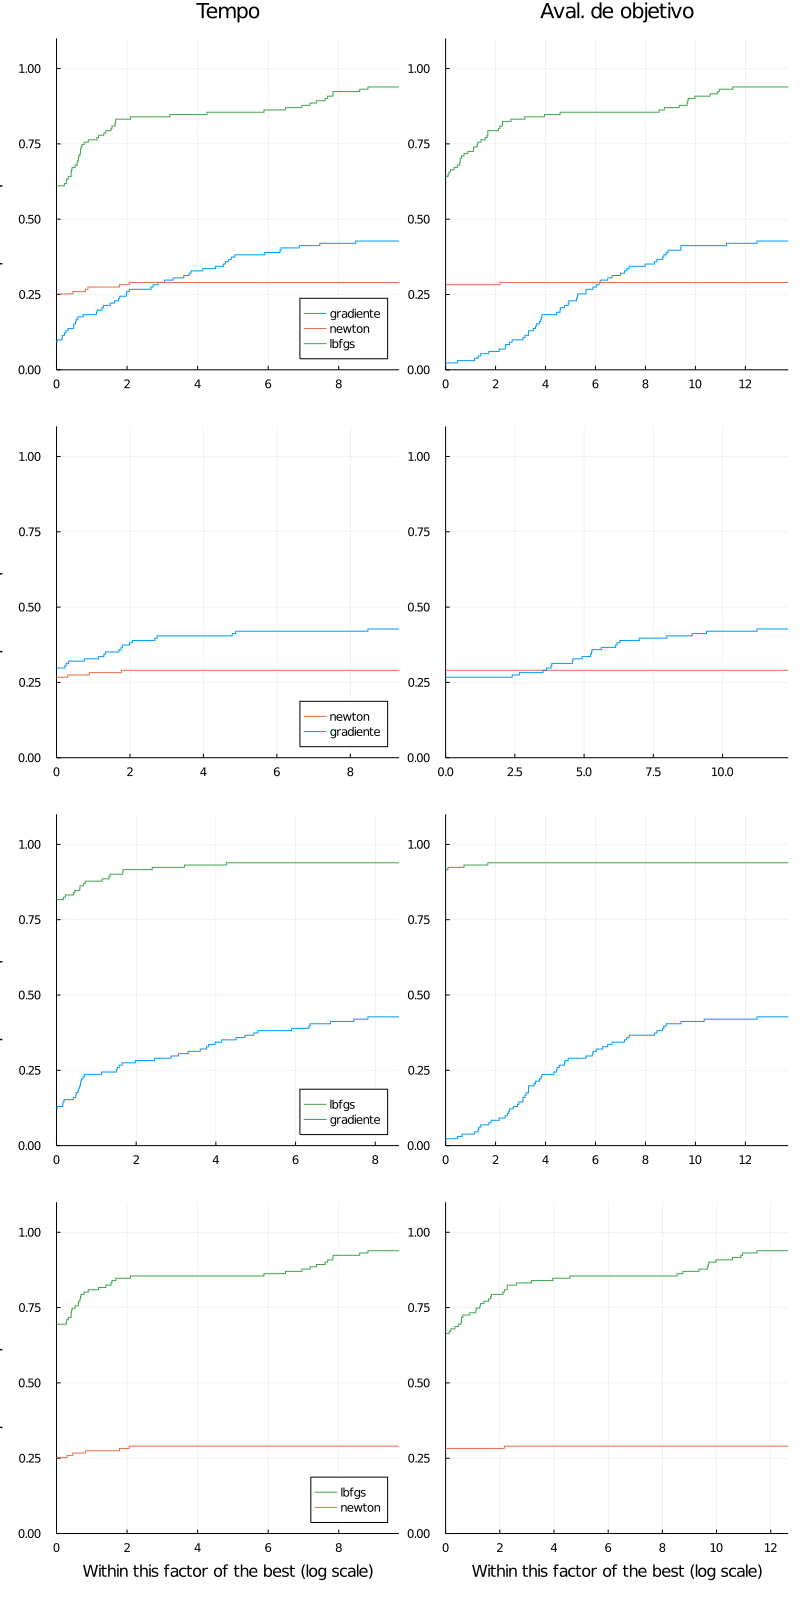

In [121]:
costs = [
    df -> (df.status .!= :first_order) * Inf + df.elapsed_time,
    df -> (df.status .!= :first_order) * Inf + df.neval_obj
]
costnames = [
    "Tempo",
    "Aval. de objetivo"
]
profile_solvers(stats, costs, costnames)

In [124]:
?pretty_stats

search: pretty_stats pretty_latex_stats



```
pretty_stats(df; kwargs...)
```

Pretty-print a DataFrame using PrettyTables.

### Arguments

  * `io::IO`: an IO stream to which the table will be output (default: `stdout`);
  * `df::DataFrame`: the DataFrame to be displayed. If only certain columns of `df` should be displayed,     they should be extracted explicitly, e.g., by passing `df[!, [:col1, :col2, :col3]]`.

### Keyword Arguments

  * `col_formatters::Dict{Symbol, String}`: a Dict of format strings to apply to selected columns of `df`.     The keys of `col_formatters` should be symbols, so that specific formatting can be applied to specific columns.     By default, `default_formatters` is used, based on the column type.     If PrettyTables formatters are passed using the `formatters` keyword argument, they are applied     before those in `col_formatters`.
  * `hdr_override::Dict{Symbol, String}`: a Dict of those headers that should be displayed differently than     simply according to the column name (default: empty). Example: `Dict(:col1 => "column 1")`.

All other keyword arguments are passed directly to `pretty_table`. In particular,

  * use `tf=markdown` to display a Markdown table;
  * do not use this function for LaTeX output; use `pretty_latex_stats` instead;
  * any PrettyTables highlighters can be given, but see the predefined `passfail_highlighter` and `gradient_highlighter`.


In [129]:
pretty_stats(stats[:newton][:,[:name,:status,:objective]])

┌────────────┬─────────────┬───────────┐
│       name │      status │ objective │
├────────────┼─────────────┼───────────┤
│      JUDGE │ first_order │  1.61e+01 │
│  FBRAIN3LS │    not_desc │  1.02e+01 │
│    WAYSEA2 │ first_order │  2.16e-08 │
│   BROWNDEN │ first_order │  8.58e+04 │
│   HILBERTA │ first_order │  2.96e-31 │
│   PALMER5D │ first_order │  8.73e+01 │
│   BOXBODLS │    not_desc │  1.86e+05 │
│   HIMMELBB │    not_desc │  2.67e+04 │
│    ENGVAL2 │    not_desc │  6.29e+02 │
│ MUONSINELS │    not_desc │  6.13e+04 │
│     ENSOLS │    not_desc │  1.15e+03 │
│     PRICE4 │    not_desc │  1.34e+04 │
│ CERI651ELS │    not_desc │  3.71e+01 │
│     SISSER │ first_order │  1.07e-08 │
│    TRIGON1 │    not_desc │  2.97e+00 │
│   MGH17SLS │    not_desc │  8.78e+04 │
│   GROWTHLS │    not_desc │  8.60e+04 │
│    SINEVAL │ first_order │  2.11e-18 │
│   GAUSS2LS │ first_order │  1.25e+03 │
│    STRATEC │    not_desc │  2.82e+03 │
│   NELSONLS │    not_desc │  6.31e+01 │
│  MISRA1ALS │  

In [130]:
pretty_latex_stats(stats[:newton][:,[:name,:status,:objective]])

\begin{longtable}{rrr}
\hline
name & status & objective \\\hline
\endhead
\hline
\multicolumn{3}{r}{{\bfseries Continued on next page}}\\
\hline
\endfoot
\endlastfoot
JUDGE & first\_order & \( 1.61\)e\(+01\) \\
FBRAIN3LS & not\_desc & \( 1.02\)e\(+01\) \\
WAYSEA2 & first\_order & \( 2.16\)e\(-08\) \\
BROWNDEN & first\_order & \( 8.58\)e\(+04\) \\
HILBERTA & first\_order & \( 2.96\)e\(-31\) \\
PALMER5D & first\_order & \( 8.73\)e\(+01\) \\
BOXBODLS & not\_desc & \( 1.86\)e\(+05\) \\
HIMMELBB & not\_desc & \( 2.67\)e\(+04\) \\
ENGVAL2 & not\_desc & \( 6.29\)e\(+02\) \\
MUONSINELS & not\_desc & \( 6.13\)e\(+04\) \\
ENSOLS & not\_desc & \( 1.15\)e\(+03\) \\
PRICE4 & not\_desc & \( 1.34\)e\(+04\) \\
CERI651ELS & not\_desc & \( 3.71\)e\(+01\) \\
SISSER & first\_order & \( 1.07\)e\(-08\) \\
TRIGON1 & not\_desc & \( 2.97\)e\(+00\) \\
MGH17SLS & not\_desc & \( 8.78\)e\(+04\) \\
GROWTHLS & not\_desc & \( 8.60\)e\(+04\) \\
SINEVAL & first\_order & \( 2.11\)e\(-18\) \\
GAUSS2LS & first\_order & \(